# Project 2: MNIST with k-means

##by Netra Mittal

### Introduction

The K-Means algorithm is powerful unsupervised machine learning algorithm. It gives us a way to enhance the K-NN prediction tool by partitioning _n_ observations into _k_ clusters to then compute the centroids of the _k_ clusters. In this project, we'll be exploring how we can use K-Means to improve the accuracy of predicting MNIST images. We start by importing the necessary libraries and data and clustering the data in part 1. Part 2 goes on to reduce the size of the training data and implement the K-NN algorithm using `sklearns`. 

In [ ]:
import numpy as np #numpy for processing
import matplotlib.pyplot as plt #matplotlib for visualizations
import gzip #gzip to process binary data
import sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with gzip.open("/content/sample_data/train-images-idx3-ubyte.gz","rb") as foo: ##opening and reading a binary file containing data on images
    f = foo.read()
    
with gzip.open("/content/sample_data/train-labels-idx1-ubyte.gz","rb") as foo2: ##opening and reading a file containing labels for images
    f2 = foo2.read()

In [ ]:
images = np.array([b for b in f[16:]]).reshape(-1, 28*28) #reshape images as a 28x28 grid
labels = np.array([b for b in f2[8:]])

### Part 1: Splitting MNIST images into 10 clusters

In [ ]:
from sklearn.cluster import KMeans #importing KMeans

In [ ]:
ks = KMeans(n_clusters=10) #initializing clusters
ks.fit(images) #fits into ten clusters
len(ks.labels_) #60,000 images and labels in dataset

60000

In [ ]:
ks.labels_ #a vector containing 60,000 labels coressponding to each image

array([2, 8, 4, ..., 8, 4, 6], dtype=int32)

Now that we have our K-Means algorithm set up, we can plot what the clusters look like based on their labels.

In [ ]:
selection = np.isin(labels, [4, 9]) #selecting two groups
selection

array([False, False, False, ..., False, False, False])

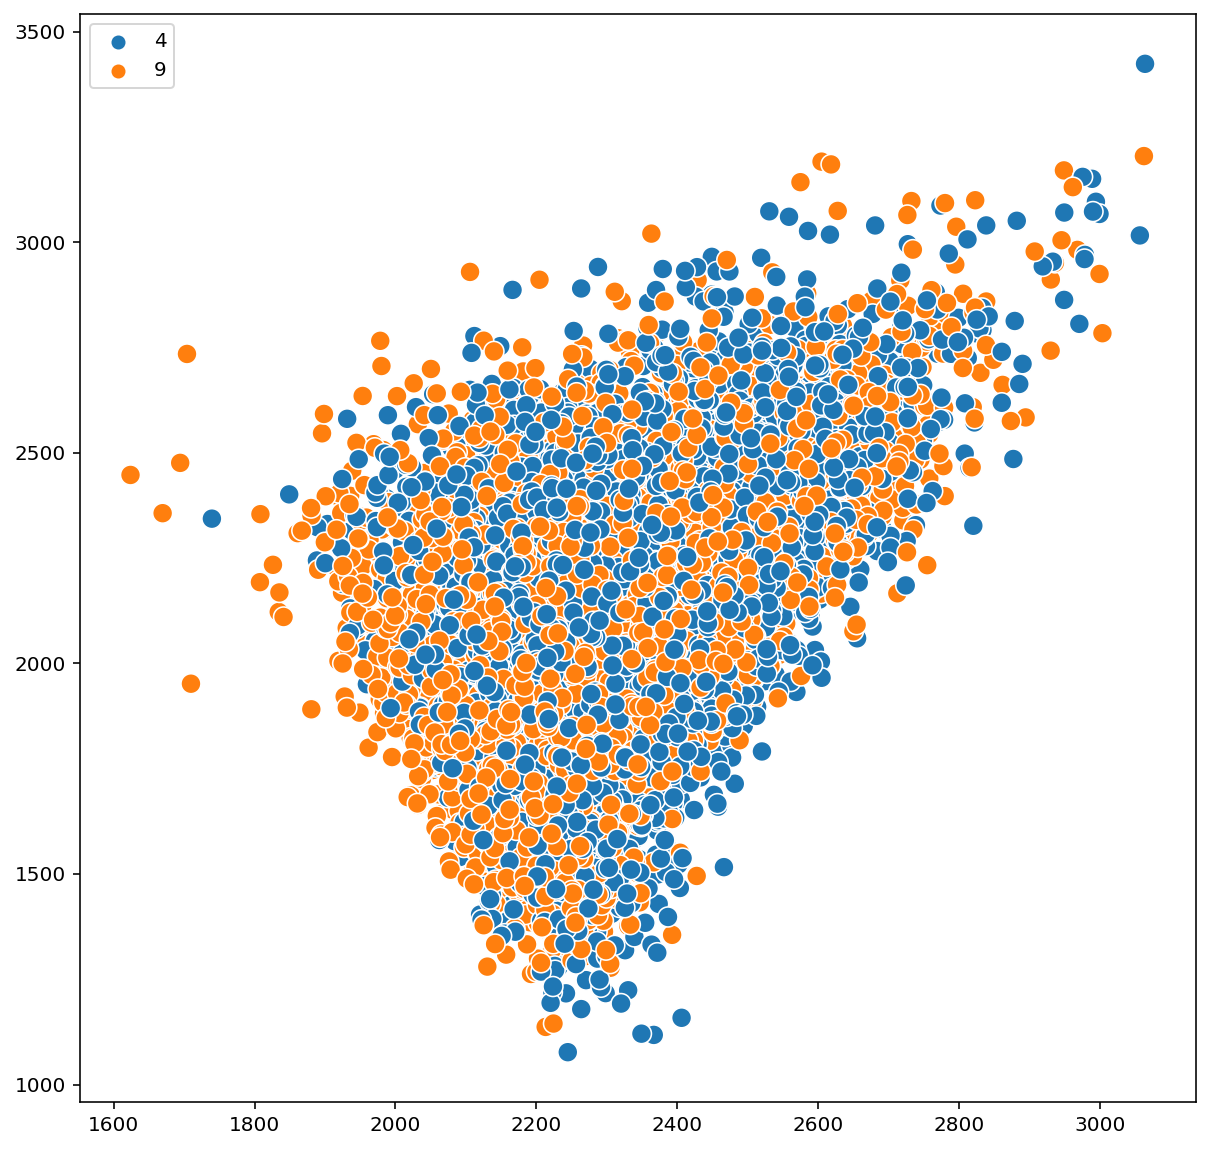

In [ ]:
plt.figure(figsize=(10,10)) #plotting clusters
sns.scatterplot(x= reduced[selection,0],
                y= reduced[selection,1],
                hue=labels[selection],
                palette='tab10',
                s=100               
               ); 

Here, we can see quite a bit of overlap between groups 4 and 9. This could correspond to digits that look very similar while writing them down, such as 3 and 8 or 0 and 9. 

Finally, we can grab and visualize the centroids of each of the ten clusters:

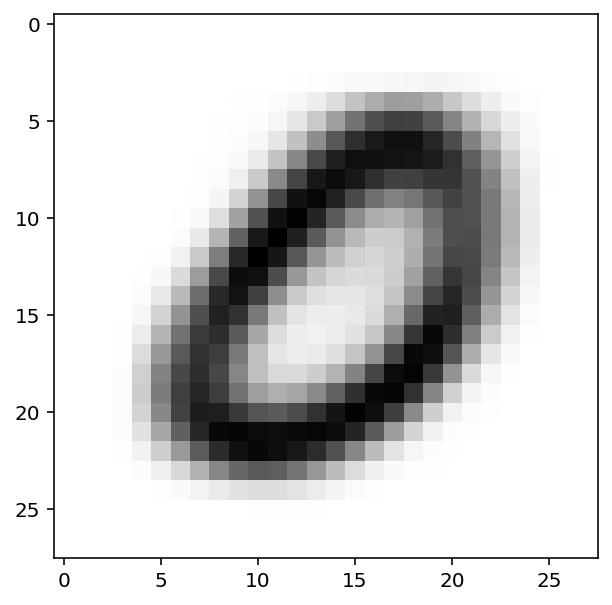

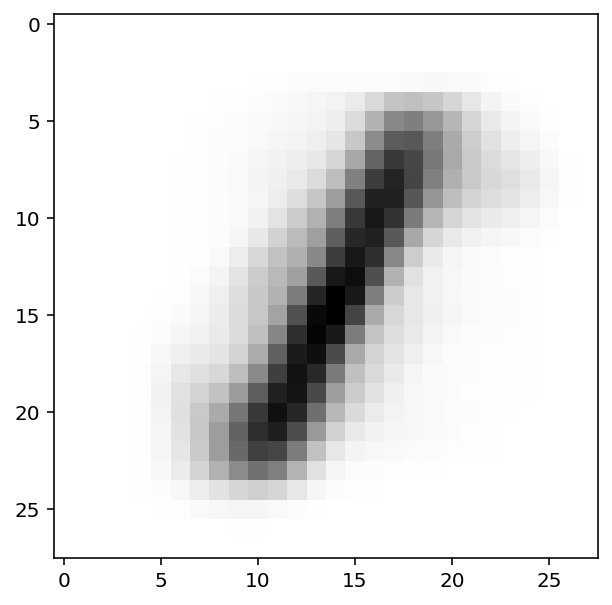

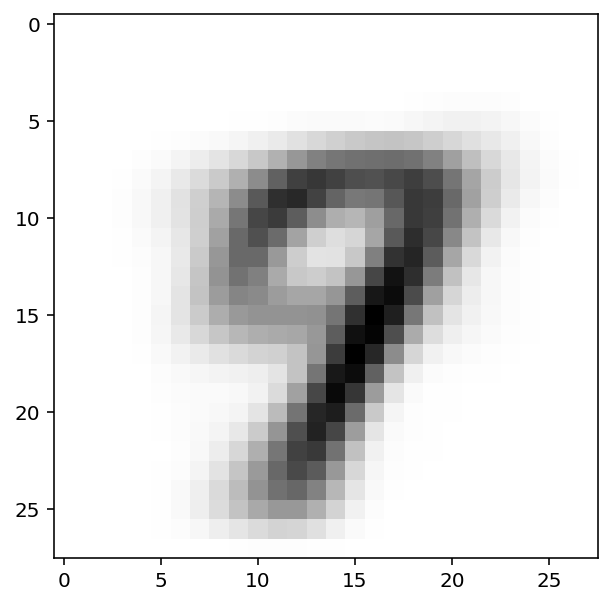

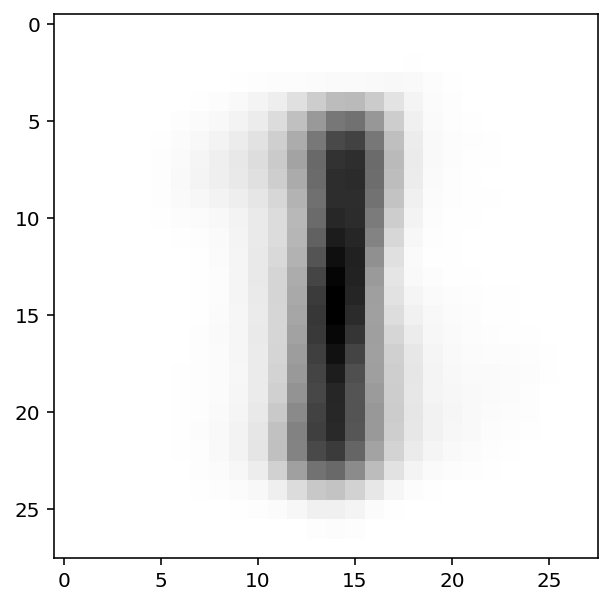

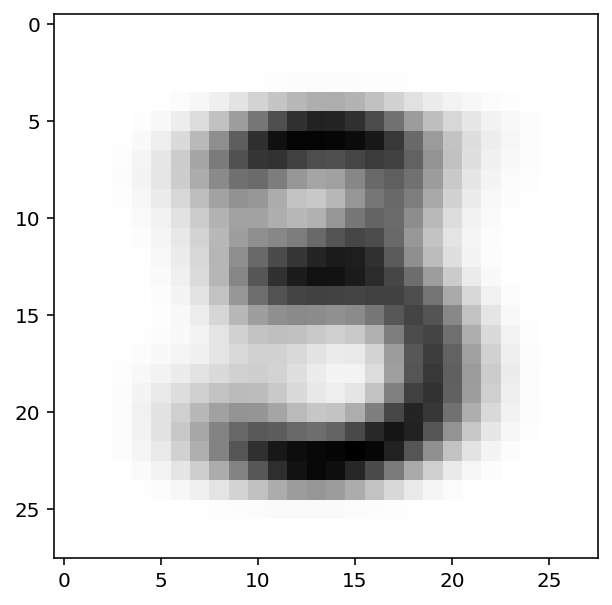

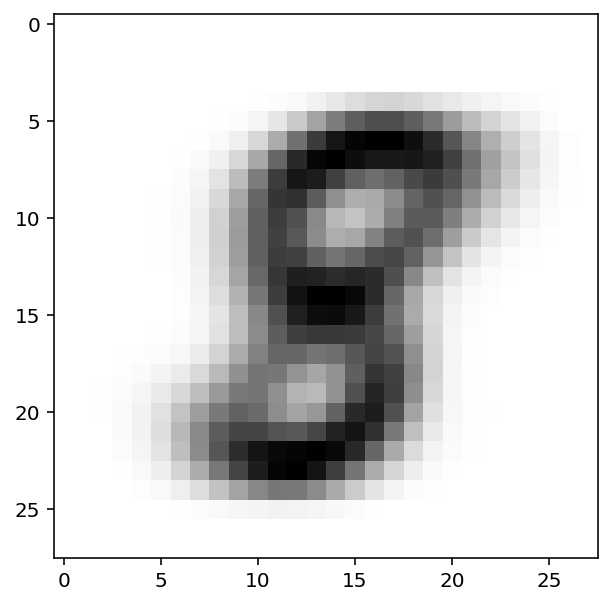

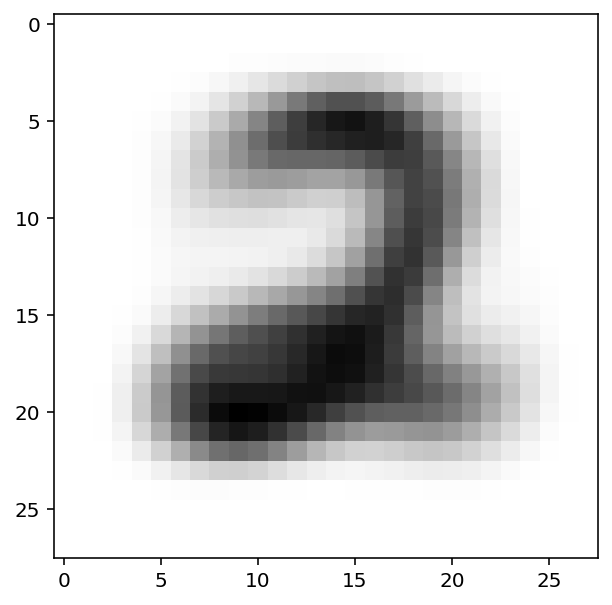

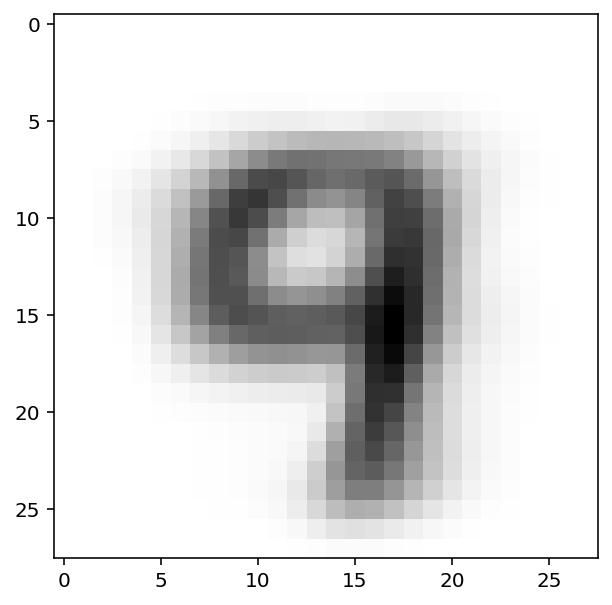

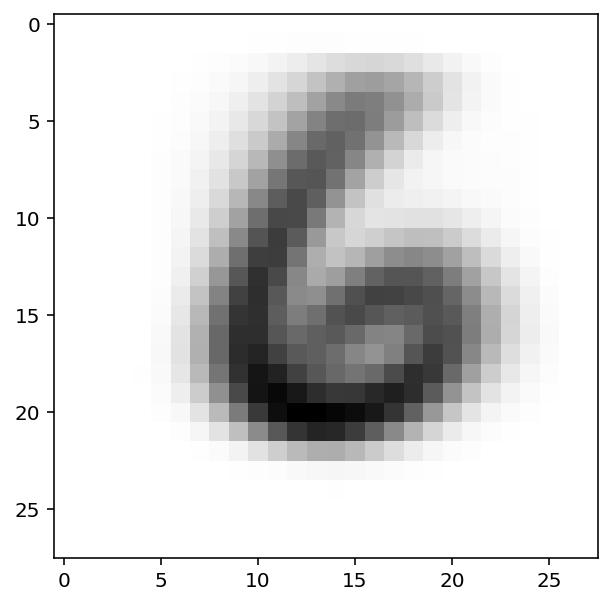

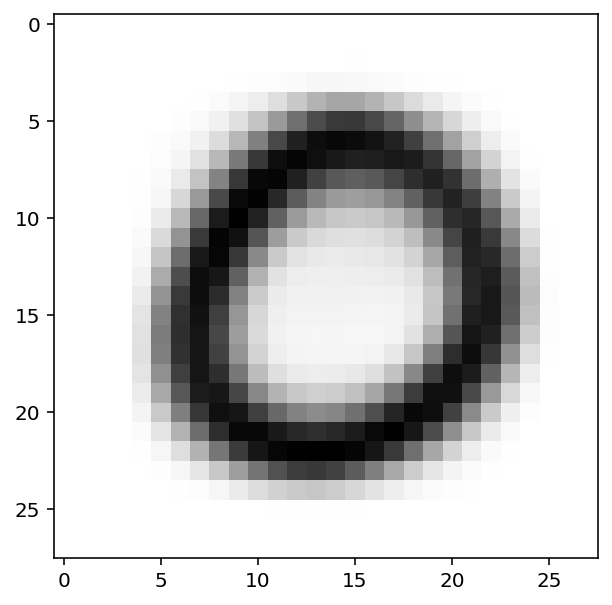

In [ ]:
centroids = ks.cluster_centers_ #grabs centroids
for i in centroids:  #for each, we reshape and print
    with np.printoptions(linewidth= 5*28):
            plt.figure(figsize=(5,5))
            plt.imshow(i.reshape(28,28), cmap="binary");

It's easy to say that these indeed look like numbers. They aren't however, unique, with 9s and 0s repeating for instance. Thus, this suggests that while the K-Means is clustering and creating centroids, it's confusing a few digits. To further see how accurately it categorizes the digits, we can create a confusion matrix.

In [ ]:
confusion = np.zeros((10, 10), dtype=int) #create a 10x10 matrix
for p in zip(labels, ks.labels_):
    confusion[p[0], p[1]] += 1

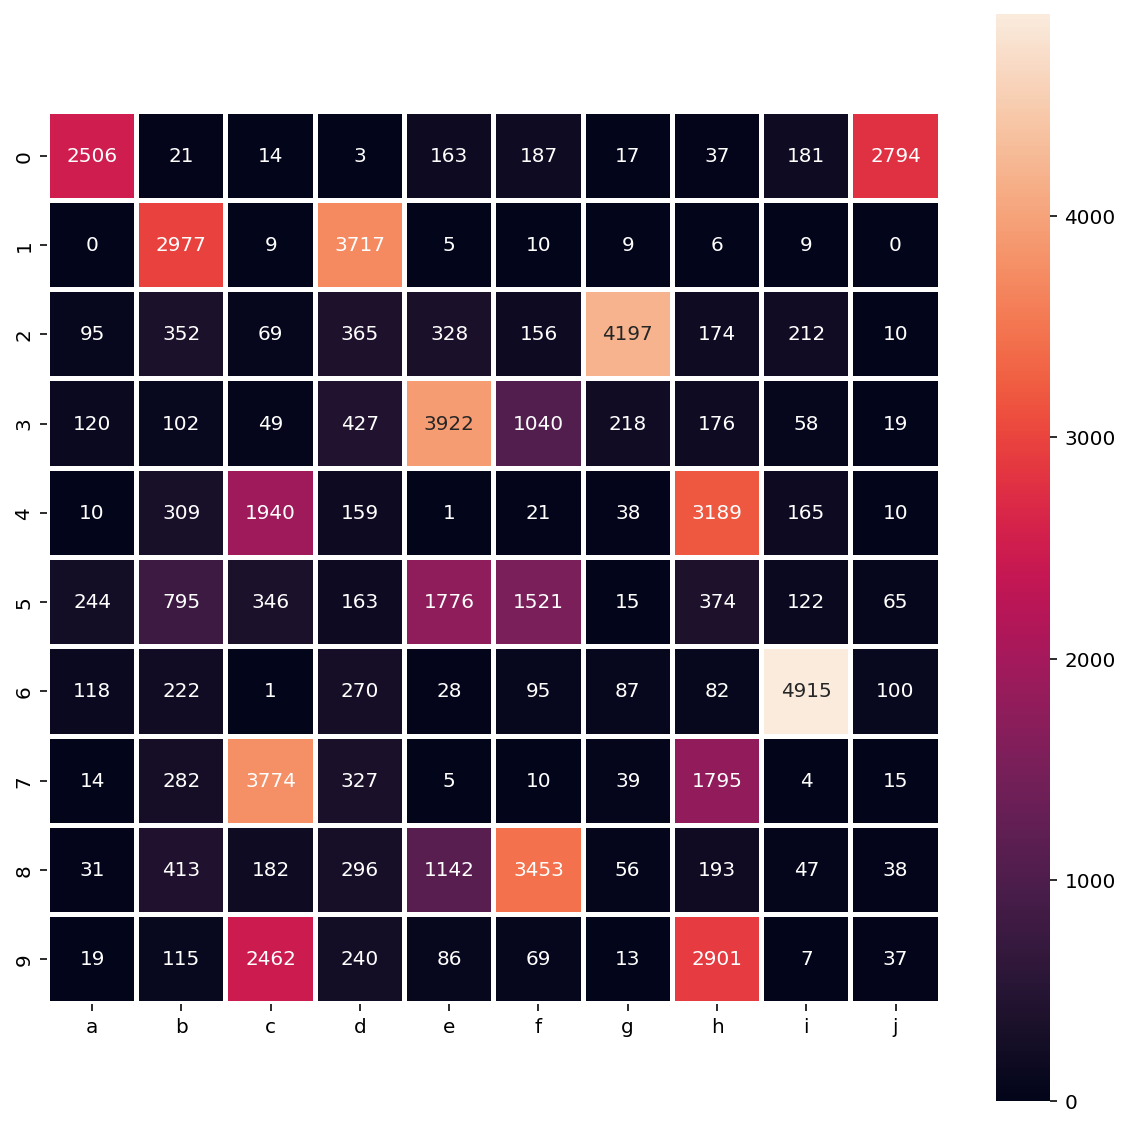

In [ ]:
import seaborn as sns #import seaborn to create a heatmap of the confusion matrix
plt.figure(figsize=(10, 10))
xlab = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j"]
sns.heatmap(confusion,
            annot=True,
            annot_kws={"fontsize": 10},
            linewidth=2, 
            square=True,
            fmt='g',
            xticklabels=xlab
           ); 

The confusion matrix helps us see how accurately the clusters are seperating numbers based on the K-Means algorithm. Here, we've matched the actual data labels (vertical) to the cluster's labels (horizontal). The warmer patches in the matrix indicate a higher match. Keeping in mind that the clusters are assigned at random, we can see that the following return the highest match for each digit: 

| Row (Actual label) | Column (Cluster Label) | Other matches (if high)|
| :----------- | :----------- :| :----------- :|
| 0      | j       | a
| 1   | d        | b
| 2      | g       | -
| 3   | e      | f
| 4      | h       | c
| 5   | e        | f
| 6      | i      | -
| 7   | c        | h
| 8      | f       | e
| 9  | h      | c

Based on this table, we can see that the highest matches are for the digits 6 and 2. The lowest matches are for the digit 5 (with the algorithm confusing it for 3 and 8s). Something interesting to note is that the algorithm is distinguishing between two types of 0's by splitting it into clusters a and j (which are the most accurate for the actual label 0). 

While showing this particularity, the algorithm still mistakes 5's for 3's. As the algorithm measures the Euclidean distance, this confusion makes sense: 3's are just backward 5's. For 0's on the other hand, this confusion could be brought about by _size_ differences in the way the digit is written and stored in the images of digit 0, causing it to look like another number.      




In [ ]:
train_num = 10000 #use 10k images to train the model
test_num = 1000 #use 1k images to test accuracy of the model

rng = np.random.default_rng(2) #we can randomize which data is selected as "training" vs "testing"
reorder = rng.permutation(len(images)) #this returns the index of the random order

images = images[reorder] #we can use the new order to reorganize the images and labels
labels = labels[reorder]

train_images = images[:train_num] #setting the training images and its associated labels
train_labels = labels[:train_num]
    
test_images = images[train_num: train_num + test_num] #setting the testing images and its associated labels
test_labels = labels[train_num: train_num + test_num]

The training data is of dimensions (10000, 784). Our goal is to reduce this to (1000, 784) to improve the speed and accuracy of our K-NN model.

In [ ]:
train_images.shape

(10000, 784)

The way we'll do this is  by making the rows smaller by computing new data that is representative of the entire training set but in reduced rows.
- First, we'll take all training images of a digit, say 1, (assume it's a thousand images of 1s). 
- We then split it into _k_ clusters and the centers then represent the training images of 1. 
- Thus, we can reduce the rows from a thousand to _k_ rows which are the centers of the clusters. 
- Then we check how much the accuracy changes when you adjust by comparing the (10k, 784) model to the new (1k, 784).

In [ ]:
myl = [[], [], [], [], [], [], [], [], [], []] #list for images of each digit
clist = [] #list for centers of each image in myl
lab = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #label of each digit
for i in range(len(train_images)): 
  for k in lab:
    if train_labels[i] ==k:            #if the label corresponds to that of the training set
      myl[k].append(train_images[i]) #we append to myl

km = KMeans(n_clusters=100) #initialize k means for 100 clusters
for i in lab: 
  km.fit(myl[i]) #fit the data for each digit
  clist.append(km.cluster_centers_) #append each center of the cluster to clist for each digit

We can test if this worked:

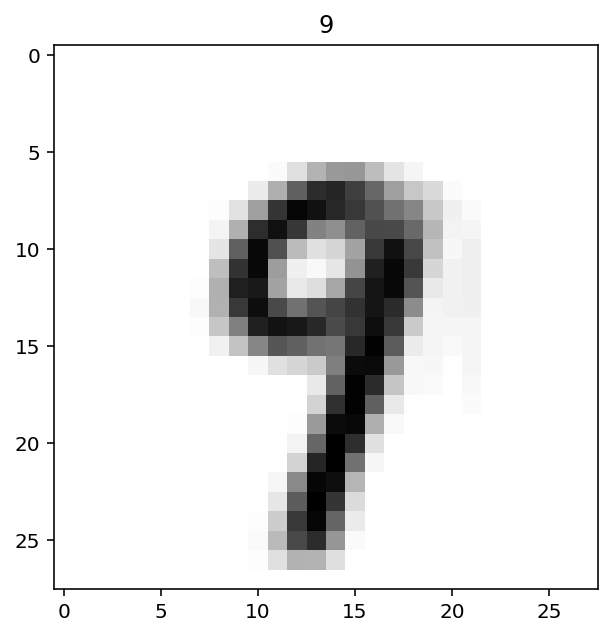

In [ ]:
index = 9
sub= 0
with np.printoptions(linewidth= 5*28):
            plt.figure(figsize=(5,5))
            plt.title(index)
            plt.imshow(clist[index][sub].reshape(28,28), cmap="binary"); #printing for clist[9][0] which should be 9

Our lists are accurate and ready to use to implement the K-NN algorithm. 

## **Part 2a: Looking at KNN predictions**

Now we can implement our model given our reduced training set. We first set up our K-NN algorithm using `sklearns`. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier #import the package  

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
#making the training list which is a flattened clist

train_data = [i for sub in clist for i in sub]
train_data= np.array(train_data)

(1000, 784)

In [ ]:
#creating a list for labels corresponding to each clist digit 
clab = []
for m in lab:
  for i in range(100):
    clab.append(m)
clab = np.array(clab)

In [ ]:
knn.fit(train_data, clab) #fit the data and labels

KNeighborsClassifier()

In [ ]:
p = test_images #the shape of our training data is (1000, 784) as compared to (10000, 784)
p.shape

(1000, 784)

In [ ]:
a = knn.predict(p)

Now that we've set up our predictions, we can take a look at the accuracy by creating a confusion matrix of actual test labels vs the predicted ones. 

In [ ]:
confusion = np.zeros((10, 10), dtype=int) #create a 10x10 matrix
for p in zip(test_labels, a):
    confusion[p[0], p[1]] += 1

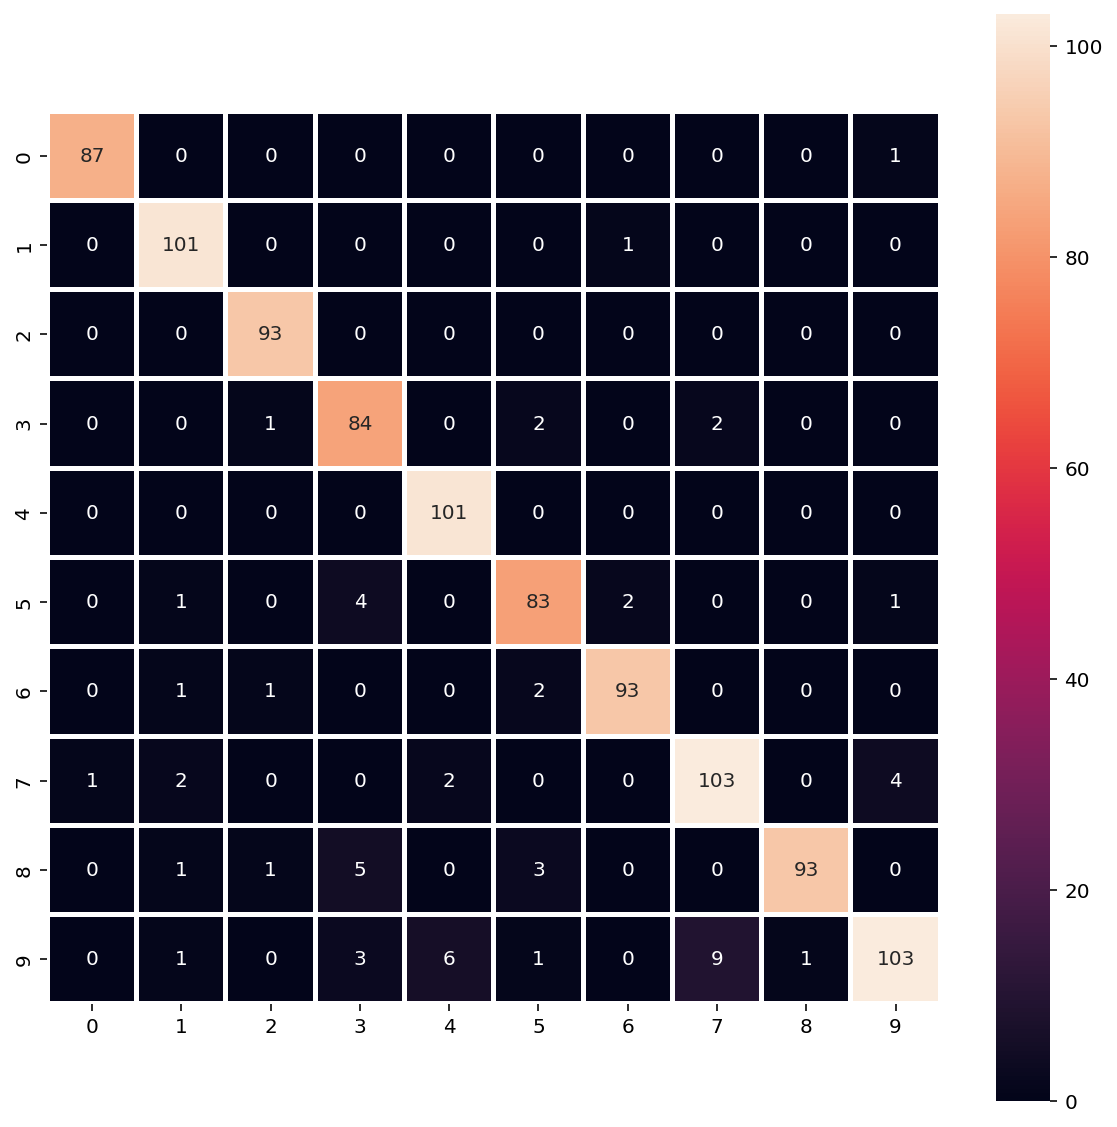

In [ ]:
plt.figure(figsize=(10,10)) #plotting the confusion matrix
sns.heatmap(confusion,
            annot=True,
            annot_kws={"fontsize": 10},
            linewidth=2, 
            square=True,
            fmt='g',
           ); 

This displays a match occuring diagonally, implying a highly accurate set of predictions by the K-NN algorithm. 

This is in stark contrast to our initial confusion matrix with inaccurate cluster matches. Thus, this exercise indicates that sub-dividing clusters is highly useful in increasing the accurary of our K-NN algorithm. This is most likely because the K-Means algorithm relies on computing the averages, or centers of the clusters. Hence, it picks out matches that are the most representative of each cluster. This bumps up the accuracy as the testing images can now be compared to what an "average" image from the cluster looks like. 